# Visualise Olympics 2021 medal data 

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import geopandas as gpd

import warnings
warnings.simplefilter("ignore")

In [117]:
def annotate(ax, title):
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width()/2, p.get_y() + p.get_height()/2), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')
                    
        ax.set_title(title)

## Read and process the dataset
Let's use the [Olympics 2021](https://www.kaggle.com/arjunprasadsarkhel/2021-olympics-in-tokyo) dataset to illustrate the use of Sankey diagram

In [78]:
df_medals = pd.read_excel("data/Medals.xlsx")
print(df_medals.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rank           93 non-null     int64  
 1   Team/NOC       93 non-null     object 
 2   Gold           93 non-null     int64  
 3   Silver         93 non-null     int64  
 4   Bronze         93 non-null     int64  
 5   Total          93 non-null     int64  
 6   Rank by Total  93 non-null     int64  
 7   Unnamed: 7     0 non-null      float64
 8   Unnamed: 8     1 non-null      float64
dtypes: float64(2), int64(6), object(1)
memory usage: 6.7+ KB
None


- We need only the Rank, Country, Medals information. So, let's drop the Rank by Total and the Unnamed columns
- There is no missing data and no missing data handling is needed

In [79]:
df_medals.rename(columns={'Team/NOC':'Country', 'Total': 'Total Medals', 'Gold':'Gold Medals', 'Silver': 'Silver Medals', 'Bronze': 'Bronze Medals'}, inplace=True)
df_medals.drop(columns=['Unnamed: 7','Unnamed: 8','Rank by Total'], inplace=True)
df_medals

,Rank,Country,Gold Medals,Silver Medals,Bronze Medals,Total Medals
0,1,United States of America,39,41,33,113
1,2,People's Republic of China,38,32,18,88
2,3,Japan,27,14,17,58
3,4,Great Britain,22,21,22,65
4,5,ROC,20,28,23,71
...,...,...,...,...,...,...
88,86,Ghana,0,0,1,1
89,86,Grenada,0,0,1,1
90,86,Kuwait,0,0,1,1
91,86,Republic of Moldova,0,0,1,1


## Stacked bar chart

In [115]:
df_ = df_medals[['Rank', 'Country','Gold Medals', 'Silver Medals','Bronze Medals','Total Medals']][:40]
df_5 = df_medals[['Rank', 'Country','Gold Medals', 'Silver Medals','Bronze Medals','Total Medals']][:40].iloc[:5,:]
df__5 = df_medals[['Country','Gold Medals', 'Silver Medals','Bronze Medals']][:40].iloc[:5,:]

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'United States of America'),
  Text(1, 0, "People's Republic of China"),
  Text(2, 0, 'Japan'),
  Text(3, 0, 'Great Britain'),
  Text(4, 0, 'ROC')])

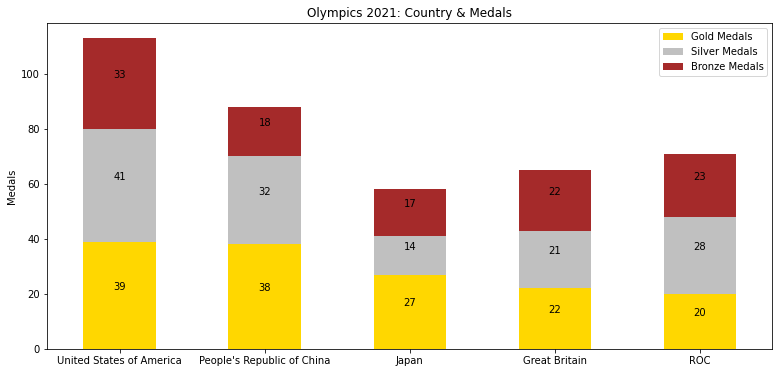

In [128]:
ax = df__5.plot.bar(stacked=True, color = ["gold", "silver", "brown"], x='Country', xlabel = '', figsize=(13,6))
ax.set_ylabel('Medals')
annotate(ax,'Olympics 2021: Country & Medals')
plt.xticks(rotation=0) 

## Parallel Coordinates 

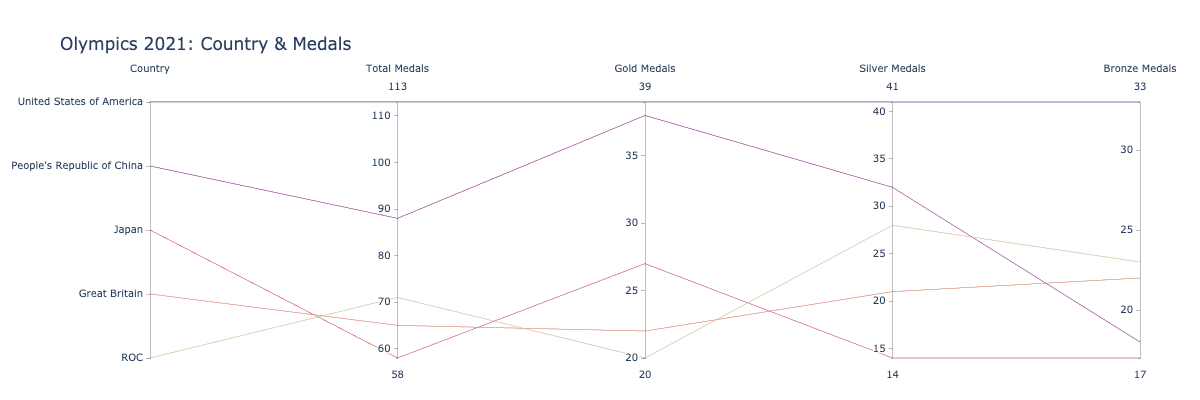

In [138]:
# Let's reverse the min and max values for the Rank, so that the country with top rank comes on the top. 
dimensions = list([ dict(range=(df_5['Rank'].max(), df_5['Rank'].min()), tickvals = df_5['Rank'], ticktext = df_5['Country'],label='Country', values=df_5['Rank']),
                    dict(range=(df_5['Total Medals'].min(), df_5['Total Medals'].max()),label='Total Medals', values=df_5['Total Medals']),
                    dict(range=(df_5['Gold Medals'].min(), df_5['Gold Medals'].max()),label='Gold Medals', values=df_5['Gold Medals']),
                    dict(range=(df_5['Silver Medals'].min(), df_5['Silver Medals'].max()),label='Silver Medals', values=df_5['Silver Medals']),
                    dict(range=(df_5['Bronze Medals'].min(), df_5['Bronze Medals'].max()),label='Bronze Medals', values=df_5['Bronze Medals']),
                  ])
fig = go.Figure(data= go.Parcoords(line = dict(color = df_5['Rank'], colorscale = 'agsunset'), dimensions = dimensions))
fig.update_layout(width=1200, height=400,margin=dict(l=150, r=60, t=100, b=40), title=go.layout.Title(text="Olympics 2021: Country & Medals"))
fig.show("png") #fig.show()

## Sankey diagram

In [83]:
import plotly.graph_objects as go
NUM_COUNTRIES = 5
X_POS, Y_POS = 0.5, 1/(NUM_COUNTRIES-1)
NODE_COLORS = ["seagreen", "dodgerblue", "orange", "palevioletred", "darkcyan"]
LINK_COLORS = ["lightgreen", "lightskyblue", "bisque", "pink", "lightcyan"]

source = []
node_x_pos, node_y_pos = [], []
node_labels, node_colors = [], NODE_COLORS[0:NUM_COUNTRIES]
link_labels, link_colors, link_values = [], [], [] 

# FIRST set of links and nodes
for i in range(NUM_COUNTRIES):
    source.extend([i]*3)
    node_x_pos.append(0.01)
    node_y_pos.append(round(i*Y_POS+0.01,2))
    country = df_medals['Country'][i]
    node_labels.append(country) 
    for medal in ["Gold", "Silver", "Bronze"]:
        link_labels.append(f"{country}-{medal}")
        link_values.append(df_medals[f"{medal} Medals"][i])
    link_colors.extend([LINK_COLORS[i]]*3)

source_last = max(source)+1
target = [ source_last, source_last+1, source_last+2] * NUM_COUNTRIES
target_last = max(target)+1

node_labels.extend(["Gold", "Silver", "Bronze"])
node_colors.extend(["gold", "silver", "brown"])
node_x_pos.extend([X_POS, X_POS, X_POS])
node_y_pos.extend([0.01, 0.5, 1])

# LAST set of links and nodes
source.extend([ source_last, source_last+1, source_last+2])
target.extend([target_last]*3)
node_labels.extend(["Total Medals"])
node_colors.extend(["grey"])
node_x_pos.extend([X_POS+0.25])
node_y_pos.extend([0.5])

for medal in ["Gold","Silver","Bronze"]:
    link_labels.append(f"{medal}")
    link_values.append(df_medals[f"{medal} Medals"][:i+1].sum())
link_colors.extend(["gold", "silver", "brown"])

'''print("source", source, source_last); print("target", target)'''
print("node_labels", node_labels)
print("node_x_pos", node_x_pos); print("node_y_pos", node_y_pos)
'''; print("node_colors", node_colors)

print("link_labels", link_labels); print("link_values", link_values)'''

node_labels ['United States of America', "People's Republic of China", 'Japan', 'Great Britain', 'ROC', 'Gold', 'Silver', 'Bronze', 'Total Medals']
node_x_pos [0.01, 0.01, 0.01, 0.01, 0.01, 0.5, 0.5, 0.5, 0.75]
node_y_pos [0.01, 0.26, 0.51, 0.76, 1.01, 0.01, 0.5, 1, 0.5]


'; print("node_colors", node_colors)\n\nprint("link_labels", link_labels); print("link_values", link_values)'

In [125]:
# Display the figure
NODES = dict(pad  = 20, thickness = 20, line  = dict(color = "lightslategrey", width = 0.5),hovertemplate=" ",
            label = node_labels, color = node_colors,
            x = node_x_pos, y = node_y_pos, )
LINKS = dict(source = source, target = target, value = link_values, 
            label = link_labels, color = link_colors,
            hovertemplate="%{label}",)
data = go.Sankey( arrangement='snap', node = NODES, link = LINKS)
fig = go.Figure(data)
fig.update_traces( valueformat='3d', valuesuffix=' Medals', selector=dict(type='sankey'))
fig.update_layout(title="Olympics 2021: Country & Medals",  font_size=16,  width=1200,height=500,)
fig.update_layout(hoverlabel=dict( bgcolor="grey", font_size=14, font_family="Rockwell"))
fig.show()

## Map

In [85]:
df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
print(f"Type of df_world: {type(df_world)} Active geometry: {df_world.geometry.name}\n")
print(f"Value counts of geometry column: {df_world.geometry.geom_type.value_counts()}\n")
df_world.head()

Type of df_world: <class 'geopandas.geodataframe.GeoDataFrame'> Active geometry: geometry

Value counts of geometry column: Polygon         148
MultiPolygon     29
dtype: int64



,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [86]:
geopandas_countries = set(df_world['name'].unique().tolist())
teams_countries = set(df_['Country'].unique().tolist())
print("geopandas_countries", len(geopandas_countries), "teams_countries", len(teams_countries))
print("Countries in teams but not found in the geo dataset")
diff_country_names = list(teams_countries-geopandas_countries); diff_country_names
diff_country_names

geopandas_countries 177 teams_countries 40
Countries in teams but not found in the geo dataset


['Czech Republic',
 'Chinese Taipei',
 'Republic of Korea',
 'Islamic Republic of Iran',
 'ROC',
 "People's Republic of China",
 'Great Britain']

In [87]:
subs = ["Bah", "Taipei", "Czech", "Domi", "Great", "Britain", "Hong", "Iran", "China", "Liech", "Korea", "ROD", "Mol", "Sing"]
for country in geopandas_countries:
    for sub in subs:
        if sub in country:
            print(sub, "- ", country)

Czech -  Czechia
Korea -  South Korea
Iran -  Iran
Korea -  North Korea
Bah -  Bahamas
China -  China
Domi -  Dominican Rep.
Mol -  Moldova


In [90]:
team_to_geopandas_countries = { "People's Republic of China" : "China",
                                'Republic of Korea': 'South Korea',
                                'Republic of Moldova':'Moldova',
                                'Czech Republic':'Czechia',
                                'Islamic Republic of Iran':'Iran',
                                'Dominican Republic':'Dominican Rep.',
                                'ROC' : 'Russia',
                                'Great Britain': 'United Kingdom'}

print(df_world[df_world['name'].str[0]=='B']['name'])
print(df_world[df_world['name'].str[0]=='H']['name'])
print(df_world[df_world['name'].str[0]=='L']['name'])
print(df_world[df_world['name'].str[0]=='R']['name'])
print(df_world[df_world['name'].str[:2]=='Si']['name'])
print(df_world[df_world['name'].str[0]=='U']['name'])

'''for country in team_to_geopandas_countries.keys():
    print(country)
    print(df_[df_['Country'] == country]['Country'].tolist()[0])'''

19              Bahamas
29               Brazil
30              Bolivia
39               Belize
49             Botswana
54                Benin
65         Burkina Faso
75              Burundi
99           Bangladesh
100              Bhutan
111             Belarus
122            Bulgaria
129             Belgium
149              Brunei
170    Bosnia and Herz.
Name: name, dtype: object
16        Haiti
36     Honduras
115     Hungary
Name: name, dtype: object
26        Lesotho
63        Liberia
77        Lebanon
92           Laos
118     Lithuania
119        Latvia
128    Luxembourg
164         Libya
Name: name, dtype: object
18      Russia
117    Romania
169     Rwanda
Name: name, dtype: object
64    Sierra Leone
Name: name, dtype: object
4      United States of America
6                    Uzbekistan
28                      Uruguay
84         United Arab Emirates
112                     Ukraine
143              United Kingdom
168                      Uganda
Name: name, dtype: object


"for country in team_to_geopandas_countries.keys():\n    print(country)\n    print(df_[df_['Country'] == country]['Country'].tolist()[0])"

In [91]:
print("Before", list(set(df_['Country'].unique().tolist()).intersection(team_to_geopandas_countries.values())), list(set(df_['Country'].unique().tolist()).intersection(team_to_geopandas_countries.keys())))
for country in team_to_geopandas_countries.keys():
    df_.loc[df_['Country'] == country, 'Country'] = team_to_geopandas_countries[country]
print("After", list(set(df_['Country'].unique().tolist()).intersection(team_to_geopandas_countries.values())), list(set(df_['Country'].unique().tolist()).intersection(team_to_geopandas_countries.keys())))

Before [] ['Czech Republic', 'Islamic Republic of Iran', 'Republic of Korea', "People's Republic of China", 'ROC', 'Great Britain']
After ['Russia', 'Czechia', 'South Korea', 'United Kingdom', 'China', 'Iran'] []


In [92]:
df_world_teams = df_world.merge(df_, how="left", left_on=['name'], right_on=['Country'])
print("Type of DataFrame : ", type(df_world_teams), df_world_teams.shape[0])
df_world_teams.head()

Type of DataFrame :  <class 'geopandas.geodataframe.GeoDataFrame'> 177


,pop_est,continent,name,iso_a3,gdp_md_est,geometry,Rank,Country,Gold Medals,Silver Medals,Bronze Medals,Total Medals
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",NaN,NaN,NaN,NaN,NaN,NaN
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",NaN,NaN,NaN,NaN,NaN,NaN
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN,NaN,NaN,NaN,NaN,NaN
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",11.0,Canada,7.0,6.0,11.0,24.0
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",1.0,United States of America,39.0,41.0,33.0,113.0


In [93]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def addColorbar():
    fig, ax = plt.subplots(1, 1, figsize=(20, 16))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad="0.5%")
    return ax, cax

Text(0.5, 1.0, 'Olympics 2021: Country & Medals')

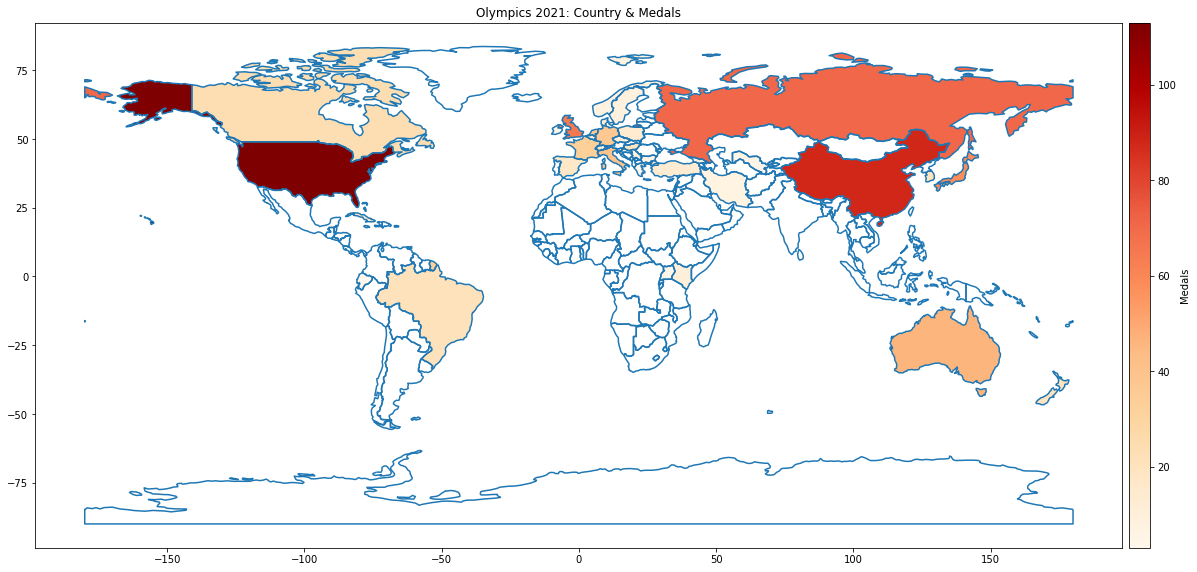

In [126]:
ax, cax = addColorbar()
df_world["geometry"].boundary.plot(ax=ax,figsize=(20,16))
df_world_teams.plot(column="Total Medals", ax=ax,  cax=cax, cmap='OrRd', 
                    legend=True, legend_kwds={"label": "Medals"},  )
ax.set_title("Olympics 2021: Country & Medals")

## Summary
We saw how Sankey diagrams can be used to represent flows effectively and how plotly python library can be to generate Sankey diagrams for a sample dataset.